### Utilities

In [1]:
import boto3
import re

def search_log_n_events(stream_names, filter_pattern, regex_pattern, num_expected_events):
    client = boto3.client('logs')

    log_group_name= "/aws/sagemaker/TrainingJobs"

    response = client.filter_log_events(
        logGroupName=log_group_name,
        logStreamNames=stream_names,
        filterPattern= filter_pattern,
        limit=10,
        interleaved=False
    )
    assert len(response["events"]) == num_expected_events
    log_message =( [e["message"] for e in response["events"]])
    
    # extract the cm from string
    prog = re.compile(regex_pattern)
    
     
    result = [ prog.match(l) for l in log_message]
    
    return result


def search_log(stream_names, filter_pattern, regex_pattern):
    result = search_log_n_events(stream_names, filter_pattern, regex_pattern, 1)[0]
    return result

def get_prf(stream_names, filterPattern):
    regex_pattern = ".*precision, recall, fscore, support\s+\((0\.\d+,\s+0\.\d+,\s+0\.\d+).*"
    
    result = search_log(stream_names, filterPattern, regex_pattern).group(1)

    # normalise string to remove extra space
    result = re.sub("\s+", "", result) 
    
    # split the string, sep by comma..514 62 41 75
    precision, recall, fscore = result.split(",")
    
    return float(precision), float(recall), float(fscore)


    
def get_prf_bert(stream_names):
    filterPattern =  '"__main__ - INFO - binary average scores"'
    return get_prf(stream_names, filterPattern)


def get_prf_bilstm(stream_names):
    filter_pattern =  '"algorithms.TrainWorkflow - INFO - binary average scores"'

    return get_prf(stream_names, filter_pattern)




def get_confusion_matrix(stream_names,filter_pattern):
    regex_pattern = ".*tn, fp, fn, tp  is \[(\d+\s+\d+\s+\d+\s+\d+\s*)\]"
    
   
    result = search_log(stream_names, filter_pattern, regex_pattern).group(1)


    # normalise string to remove extra space
    result = re.sub("\s+", " ", result) 
    
    # split the string, sep by space..514 62 41 75
    tn, fp, fn, tp = result.split(" ")
    return {"tn":int(tn), "fp":int(fp), "fn":int(fn), "tp":int(tp)}

    
def get_confusion_matrix_bilstm(stream_names):
   
    filterPattern =  '"algorithms.TrainWorkflow - INFO - Confusion matrix"'
    return get_confusion_matrix(stream_names, filterPattern)
   



def get_confusion_matrix_bert(stream_names):
    filter_pattern = '"__main__ - INFO - Confusion matrix"'
    return get_confusion_matrix(stream_names, filter_pattern)
   


def get_log_name(sagemaker_job_name):
    client = boto3.client('logs')
    log_group_name= "/aws/sagemaker/TrainingJobs"
    
    response = client.describe_log_streams(
    logGroupName=log_group_name,
    logStreamNamePrefix=sagemaker_job_name,
    orderBy='LogStreamName',
    descending=False,
    limit=5
)
    assert len(response["logStreams"]) == 1
    
    return  response["logStreams"][0]["logStreamName"]

In [2]:
import pandas as pd 
def get_bert_k_fold_scores(stream_names, k=10):
    filter_pattern = '"algorithms.main_train_bert - INFO - binary average scores"'
    regex_pattern = ".*precision, recall, fscore, support\s*\((0\.\d+,\s+0\.\d+,\s+0\.\d+).*"
    
    scores_n = []
    for match_line_regex in search_log_n_events(stream_names, filter_pattern, regex_pattern, k):
        result = match_line_regex.group(1)

        # normalise string to remove extra space
        result = re.sub("\s+", " ", result) 

        # split the string, sep by space..514 62 41 75
        precision, recall, fscore = result.split(", ")
        scores_n.append({ "precision":float(precision)*100, "recall":float(recall)*100, "fscore":float(fscore)*100})
        
    
    return pd.DataFrame(scores_n)


def get_bilstm_k_fold_scores(stream_names, k=10):
    filter_pattern = '"algorithms.TrainWorkflow - INFO - binary average scores"'
    regex_pattern = ".*precision, recall, fscore, support\s*\((0\.\d+,\s+0\.\d+,\s+0\.\d+).*"
    
    scores_n = []
    for match_line_regex in search_log_n_events(stream_names, filter_pattern, regex_pattern, k):
        result = match_line_regex.group(1)

        # normalise string to remove extra space
        result = re.sub("\s+", " ", result) 

        # split the string, sep by space..514 62 41 75
        precision, recall, fscore = result.split(", ")
        scores_n.append({ "precision":float(precision)*100, "recall":float(recall)*100, "fscore":float(fscore)*100})
        
    
    return pd.DataFrame(scores_n)

### BiLSTM Results - KFold


#### AIMED1 ALLREP  - processed  Overlap

In [22]:
job_name = "aimed-bilstm-full-processed-overlap-2019-12-28-00-25-14-344"
l = get_log_name(job_name)
df_scores_k_fold_bilstm_proc_overlap= get_bilstm_k_fold_scores([l])
df_scores_k_fold_bilstm_proc_overlap.describe()

,fscore,precision,recall
count,10.000000,10.000000,10.000000
mean,71.685655,74.589943,69.700000
std,4.469943,8.510688,6.272515
min,62.176166,64.516129,60.000000
25%,69.868864,70.668449,66.250000
50%,71.321956,71.496884,70.500000
75%,74.122246,75.669773,73.500000
max,77.647059,94.285714,78.000000


#### AIMED1 PARTREP  -  Plain  Overlap

In [25]:
job_name = "aimed-bilstm-full-plain-overlap-2019-12-28-00-25-20-717"
l = get_log_name(job_name)
df_scores_k_fold_bilstm_plain_overlap= get_bilstm_k_fold_scores([l])
df_scores_k_fold_bilstm_plain_overlap.describe()

,fscore,precision,recall
count,10.000000,10.000000,10.000000
mean,68.479734,70.489873,67.200000
std,4.033466,7.312297,5.473167
min,60.439560,60.683761,55.000000
25%,67.003062,66.282856,65.000000
50%,68.279055,68.595967,68.500000
75%,70.772059,73.670077,70.750000
max,75.409836,83.132530,73.000000


#### AIMED1 PARTREP  - Plain No  Overlap

In [28]:
job_name = "aimed-bilstm-full-plain-unique-2019-12-28-00-25-07-890"
l = get_log_name(job_name)
df_scores_k_fold_bilstm_plain_no_overlap= get_bilstm_k_fold_scores([l])
df_scores_k_fold_bilstm_plain_no_overlap.describe()

,fscore,precision,recall
count,10.000000,10.000000,10.000000
mean,52.951346,53.766565,53.756691
std,5.555749,6.083066,10.488621
min,42.000000,42.857143,32.307692
25%,50.418306,50.362319,49.885922
50%,54.444733,54.166667,54.606006
75%,55.782034,57.419397,56.361111
max,59.803922,63.541667,74.015748


#### AIMED1 ALLREP  - processed  NO Overlap

In [23]:
job_name = "aimed-bilstm-full-processed-unique-2019-12-28-00-25-01-226"
l = get_log_name(job_name)
df_scores_k_fold_bilstm_proc_no_overlap= get_bilstm_k_fold_scores([l])
df_scores_k_fold_bilstm_proc_no_overlap.describe()

,fscore,precision,recall
count,10.000000,10.000000,10.000000
mean,58.748009,57.438317,61.730147
std,6.821223,10.101098,9.085322
min,47.736626,41.428571,49.450549
25%,55.332168,48.825188,55.938135
50%,59.672676,60.284906,59.097087
75%,62.598676,65.024520,69.598291
max,70.638298,69.230769,76.851852


## Convolutional resnet 

#### AIMED1 PARTREP  - plain NO  Overlap

In [31]:
job_name = "aimed-resnet-full-plain-unique-2019-12-27-23-58-55-542"
l = get_log_name(job_name)
df_scores_k_fold_conv_plain_no_overlap= get_bilstm_k_fold_scores([l])
df_scores_k_fold_conv_plain_no_overlap.describe()

,fscore,precision,recall
count,10.000000,10.000000,10.000000
mean,52.847992,55.445898,50.880144
std,4.013822,6.510743,4.154431
min,48.192771,45.762712,43.956044
25%,49.528178,50.412088,48.518795
50%,52.486987,55.614035,51.507321
75%,56.219841,60.653846,53.234403
max,58.620690,64.761905,58.000000


#### AIMED1 ALLREP  -  Processed NO  Overlap

In [32]:
job_name = "aimed-resnet-full-processed-unique-2019-12-27-23-56-22-838"
l = get_log_name(job_name)
df_scores_k_fold_conv_proc_no_overlap= get_bilstm_k_fold_scores([l])
df_scores_k_fold_conv_proc_no_overlap.describe()

,fscore,precision,recall
count,10.000000,10.000000,10.000000
mean,56.148766,56.664144,56.403245
std,7.008196,8.145687,9.068509
min,45.497630,44.444444,43.076923
25%,50.573394,50.277778,48.687720
50%,58.492137,58.041079,57.132479
75%,62.316941,61.761848,63.705857
max,63.076923,71.428571,69.000000


#### AIMED1 ALLREP  -  Processed   Overlap

In [33]:
job_name = "aimed-resnet-full-processed-overlap-2019-12-28-00-43-47-964"
l = get_log_name(job_name)
df_scores_k_fold_conv_proc_overlap= get_bilstm_k_fold_scores([l])
df_scores_k_fold_conv_proc_overlap.describe()

,fscore,precision,recall
count,10.000000,10.000000,10.000000
mean,69.919286,71.097753,69.200000
std,3.640958,6.102448,5.028806
min,62.105263,62.162162,59.000000
25%,70.060976,68.571429,66.500000
50%,70.416069,69.436813,69.500000
75%,71.546283,75.058140,72.000000
max,74.316940,81.927711,78.000000


#### AIMED1 PARTREP  -  Plain   Overlap

In [34]:
job_name = "aimed-resnet-full-plain-overlap-2019-12-28-00-43-11-658"
l = get_log_name(job_name)
df_scores_k_fold_conv_plain_overlap= get_bilstm_k_fold_scores([l])
df_scores_k_fold_conv_plain_overlap.describe()

,fscore,precision,recall
count,10.000000,10.000000,10.000000
mean,61.242149,62.422715,60.600000
std,4.113111,5.586561,6.058969
min,52.747253,53.271028,48.000000
25%,60.925477,57.666933,57.750000
50%,62.874815,63.861386,61.000000
75%,63.157895,66.489362,63.750000
max,65.671642,70.886076,70.000000


### BioBert Results - KFold

#### AIMED1 ALLREP  - processed  overlap

In [4]:
job_name = "aimed-bert-proc-overlap-2019-12-27-09-12-26-702"
l = get_log_name(job_name)
df_scores_k_fold_bert_proc_overlap= get_bert_k_fold_scores([l])
df_scores_k_fold_bert_proc_overlap.describe()

,fscore,precision,recall
count,10.000000,10.000000,10.000000
mean,77.934590,79.779867,76.700000
std,5.189706,6.519429,7.439385
min,72.115385,69.444444,67.000000
25%,75.161688,74.943845,71.250000
50%,77.238403,79.755385,77.500000
75%,78.306165,84.967631,79.750000
max,90.099010,89.215686,91.000000


#### AIMED1 PARTREP – plain overlap

In [5]:
job_name = "aimed-bert-plain-overlap-2019-12-27-09-08-55-742"
l = get_log_name(job_name)
df_scores_k_fold_bert_plain_overlap= get_bert_k_fold_scores([l])
df_scores_k_fold_bert_plain_overlap.describe()

,fscore,precision,recall
count,10.000000,10.000000,10.000000
mean,75.433009,77.039582,74.300000
std,4.162674,6.092692,5.755191
min,71.361502,67.256637,68.000000
25%,72.267223,74.104824,68.750000
50%,74.266941,75.543735,75.000000
75%,76.851556,81.601124,76.000000
max,84.158416,86.075949,85.000000


#### AIMED1 ALLREP  -  processed  no overlap

In [6]:
job_name = "aimed-bert-proc-2019-12-27-09-11-10-938"
l = get_log_name(job_name)
df_scores_k_fold_bert_proc_nooverlap= get_bert_k_fold_scores([l])
df_scores_k_fold_bert_proc_nooverlap.describe()

,fscore,precision,recall
count,10.000000,10.000000,10.000000
mean,64.410995,65.829694,63.663404
std,5.002985,5.220672,7.806721
min,56.962025,54.954955,49.450549
25%,61.493808,62.980538,60.015766
50%,65.460153,66.915423,63.538835
75%,68.040184,69.605263,70.691860
max,70.817121,71.428571,72.222222


#### AIMED1 PARTREP – plain no overlap

In [7]:
job_name = "aimed-bert-plain-2019-12-27-09-04-56-235"
l = get_log_name(job_name)
df_scores_k_fold_bert_plain_nooverlap= get_bert_k_fold_scores([l])
df_scores_k_fold_bert_plain_nooverlap.describe()

,fscore,precision,recall
count,10.000000,10.000000,10.000000
mean,61.875675,63.465510,62.175372
std,13.393258,8.917919,19.502255
min,40.718563,48.818898,33.009709
25%,52.667450,56.145485,48.028468
50%,63.477931,65.091437,60.597087
75%,72.664721,70.032051,78.287037
max,78.512397,76.000000,91.860465


### BERT Variance

In [8]:
bert_jobs = ["aimed-bert-plain-split-2019-12-27-02-26-02-690",
"aimed-bert-plain-split-2019-12-27-02-25-43-027",
"aimed-bert-plain-split-2019-12-27-02-25-28-691",
"aimed-bert-plain-split-2019-12-27-02-25-09-463",
"aimed-bert-plain-split-2019-12-27-02-24-48-346",
"aimed-bert-plain-split-2019-12-27-02-24-16-129",
"aimed-bert-plain-split-2019-12-27-02-23-47-725",
"aimed-bert-plain-split-2019-12-27-02-23-27-656",
"aimed-bert-plain-split-2019-12-27-02-23-02-670",
"aimed-bert-plain-split-2019-12-27-02-22-35-468",]

In [9]:
scores_bert = {}
for k in bert_jobs:
    l = get_log_name(k)
    (p,r,f) = get_prf_bert([l])
    cm  = get_confusion_matrix_bert([l]) 
    scores_bert[k] = {"fpr":(p,r,f) , "cm" : cm }




In [10]:
import pandas as pd 

def create_variation_df(scores_map):
    result = []
    for k in scores_map:
        p,r,f=scores_map[k]["fpr"]
        cm = scores_map[k]["cm"]
       
        accuracy = float(cm["tp"] + cm["tn"])/float(cm["tp"] + cm["tn"] + cm["fp"] + cm["fn"])
        b= float( cm["tn"] +  cm["fp"]  )/float(cm["tp"] + cm["tn"] + cm["fp"] + cm["fn"])
        result.append({"Precision": p *100, "Recall": r*100, "F1-score": f * 100, "Accuracy": accuracy*100, "BaselineAcc":b*100})

    df =  pd.DataFrame(result)
    return df

In [11]:
df_val_scores_bert = create_variation_df(scores_bert)
df_val_scores_bert.describe()

,Accuracy,BaselineAcc,F1-score,Precision,Recall
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,89.034335,81.974249,68.407107,71.444574,66.071429
std,1.249026,0.000000,3.668703,5.028211,6.204959
min,87.339056,81.974249,64.242424,64.835165,58.333333
25%,88.251073,81.974249,66.021505,68.187831,61.309524
50%,88.733906,81.974249,67.275930,71.130952,64.285714
75%,89.699571,81.974249,69.910911,74.207746,69.940476
max,91.416309,81.974249,76.744186,79.104478,78.571429


In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(10, 5))

df_val_scores_bert[["Precision", "Recall", "F1-score", "Accuracy"]].boxplot(ax=ax[0])

plt.savefig("score_variation_aimed_bert.png", bbox_inches='tight')




In [13]:
df_val_scores_bert.describe()

,Accuracy,BaselineAcc,F1-score,Precision,Recall
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,89.034335,81.974249,68.407107,71.444574,66.071429
std,1.249026,0.000000,3.668703,5.028211,6.204959
min,87.339056,81.974249,64.242424,64.835165,58.333333
25%,88.251073,81.974249,66.021505,68.187831,61.309524
50%,88.733906,81.974249,67.275930,71.130952,64.285714
75%,89.699571,81.974249,69.910911,74.207746,69.940476
max,91.416309,81.974249,76.744186,79.104478,78.571429


### LSTM Variance no overlap

In [14]:
bilstm_job_name = ["aimed-bilstm-split-2019-12-27-07-28-15-601",
"aimed-bilstm-split-2019-12-27-07-28-02-071",
"aimed-bilstm-split-2019-12-27-07-27-54-082",
"aimed-bilstm-split-2019-12-27-07-27-37-532",
"aimed-bilstm-split-2019-12-27-07-27-22-429",
"aimed-bilstm-split-2019-12-27-07-27-09-765",
"aimed-bilstm-split-2019-12-27-07-26-58-798",
"aimed-bilstm-split-2019-12-27-07-26-40-188",
"aimed-bilstm-split-2019-12-27-07-26-29-719",
"aimed-bilstm-split-2019-12-27-07-26-13-355"]

In [15]:
scores_bilstm = {}
for j in bilstm_job_name:
    l = get_log_name(j)
    (p,r,f) = get_prf_bilstm([l])
    cm  = get_confusion_matrix_bilstm([l]) 
    scores_bilstm[j] = {"fpr":(p,r,f) , "cm" : cm }



In [16]:
sum(list(scores_bilstm["aimed-bilstm-split-2019-12-27-07-26-13-355"]["cm"].values()))

466

In [17]:
df_val_scores_bilstm = create_variation_df(scores_bilstm)

df_val_scores_bilstm.describe()

,Accuracy,BaselineAcc,F1-score,Precision,Recall
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,85.686695,81.974249,62.116127,59.938676,65.238095
std,1.346033,0.000000,2.452981,4.464460,6.659104
min,82.832618,81.974249,59.016393,51.694915,54.761905
25%,85.515021,81.974249,60.566491,58.608491,61.011905
50%,86.158798,81.974249,61.540616,60.040250,63.095238
75%,86.266094,81.974249,63.071084,61.790017,71.130952
max,87.339056,81.974249,66.315789,66.233766,75.000000


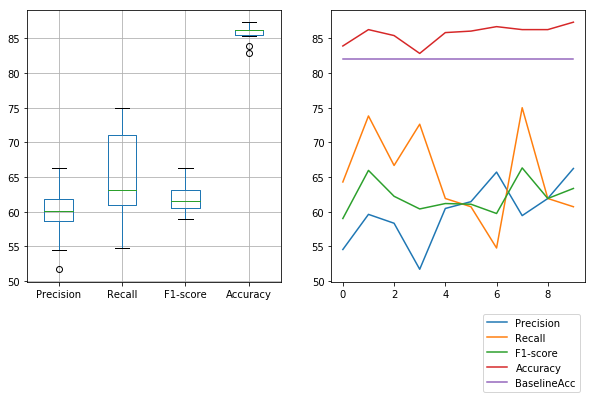

In [18]:

fig, ax = plt.subplots(1,2, figsize=(10, 5))
df_val_scores_bilstm[["Precision", "Recall", "F1-score", "Accuracy"]].boxplot(ax=ax[0])
df_val_scores_bilstm[["Precision", "Recall", "F1-score", "Accuracy", "BaselineAcc"]].plot(ax = ax[1]).legend(bbox_to_anchor=(1, -0.1))

plt.savefig("score_variation_aimed_bilstm.png", bbox_inches='tight')







In [19]:


def normalize(dataset):
    dataNorm=((dataset-dataset.min())/(dataset.max()-dataset.min()))
    return dataNorm


def standardize( df):

    avg = df.mean()
    stdv = df.std()
    series_standardized = (df - avg)/ stdv
    return series_standardized


In [20]:


df_val_scores_bilstm_norm =standardize(df_val_scores_bilstm)

df_val_scores_bilstm_norm.describe()

,Accuracy,BaselineAcc,F1-score,Precision,Recall
count,1.000000e+01,0.0,1.000000e+01,1.000000e+01,1.000000e+01
mean,7.371881e-15,NaN,1.443290e-15,1.998401e-16,-5.329071e-16
std,1.000000e+00,NaN,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.120362e+00,NaN,-1.263660e+00,-1.846530e+00,-1.573213e+00
25%,-1.275405e-01,NaN,-6.317358e-01,-2.979500e-01,-6.346485e-01
50%,3.507365e-01,NaN,-2.346167e-01,2.275171e-02,-3.217936e-01
75%,4.304493e-01,NaN,3.893047e-01,4.146842e-01,8.849325e-01
max,1.227578e+00,NaN,1.712065e+00,1.410045e+00,1.465949e+00
